In [37]:
import pvlib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pvlib.modelchain import ModelChain
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

TMY data for Abu Dhabi

<Axes: >

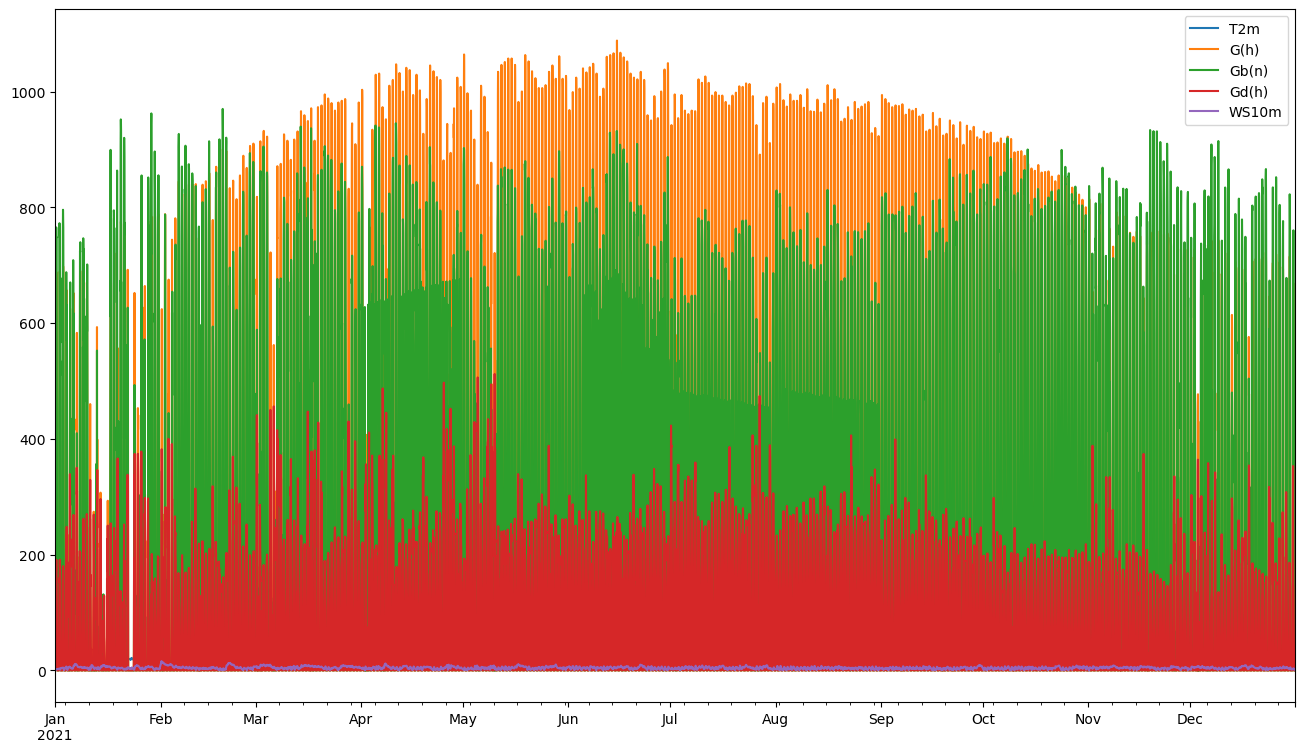

In [3]:
#Reading the local TMY file
tmy_ad=pd.read_csv('C:\\Users\\Rachael Ebenezer\\Downloads\\AD_data.csv',skiprows=16,nrows=8760, usecols=["time(UTC)", "T2m","G(h)","Gb(n)","Gd(h)","WS10m"],index_col=0)
#Defining date range
tmy_ad.index=pd.date_range(start="2021-01-01 00:00", end="2021-12-31 23:00",freq="h")
#Plotting key data
tmy_ad.plot(figsize=(16,9))

TMY for Melbourne

<Axes: >

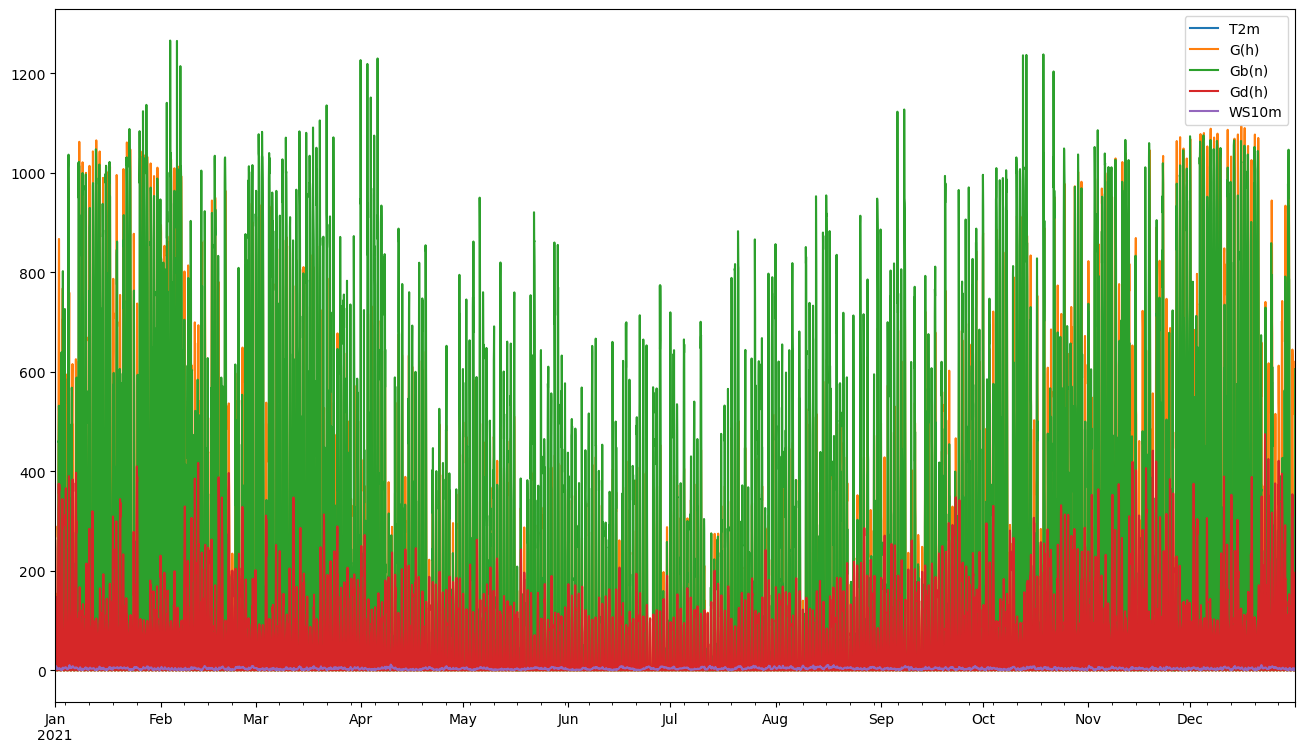

In [4]:
#Reading the local TMY file
tmy_mel=pd.read_csv('C:\\Users\\Rachael Ebenezer\\Downloads\\Mel_data.csv',skiprows=16,nrows=8760, usecols=["time(UTC)", "T2m","G(h)","Gb(n)","Gd(h)","WS10m"],index_col=0)
#Defining date range
tmy_mel.index=pd.date_range(start="2021-01-01 00:00", end="2021-12-31 23:00",freq="h")
#Plotting key data
tmy_mel.plot(figsize=(16,9))

In [62]:
#Defining a list to hold multiple lists, each corresponding to the tilt angle and global irradiance of each city 
final_list=[]
#Defining an array to hold the local location of the TMY files for different cities
Cities=['Abu Dhabi', 'Melbourne']
Coordinates=[[24.4,54.3],[37.8,144.9]]
Cities_file=['C:\\Users\\Rachael Ebenezer\\Downloads\\AD_data.csv','C:\\Users\\Rachael Ebenezer\\Downloads\\Mel_data.csv']
#Calculating global irradiance for different tilt angles in one city
for i in range(len(Cities)):
    tmy=pd.read_csv(Cities_file[i],skiprows=16,nrows=8760, usecols=["time(UTC)", "T2m","G(h)","Gb(n)","Gd(h)","WS10m"],index_col=0)
    tmy.index=pd.date_range(start="2021-01-01 00:00", end="2021-12-31 23:00",freq="h")
    latitude=Coordinates[i][0]
    longitude=Coordinates[i][1]
    Surface_azi=0
    if(latitude<0):
        Surface_azi=0
    else:
        Surface_azi=180
    SP = pvlib.solarposition.ephemeris(tmy.index, latitude, longitude)
    #Obtaining Zenith, Elevation and Azimuth
    tmy['SZA'] = SP.apparent_zenith.values
    tmy['SEA'] = SP.apparent_elevation.values
    tmy['SAA'] = SP.azimuth.values
    #Setting tilt range to calculate corresponding global irradiance
    pitch_angles= range(0,91,5)
    irradiance_tilt =[]
    tilt_angle = []
    sandia_modules=pvlib.pvsystem.retrieve_sam('SandiaMod')
    Module=sandia_modules['SolarWorld_Sunmodule_250_Poly__2013_']
    globalirr=total_irrad.poa_global
    airtemp=tmy.T2m
    windspeed=tmy.WS10m
    #Calculating cell_temp by assuming a,b and delT according to documentation
    cell_temp = pvlib.temperature.sapm_cell(poa_global=globalirr, temp_air=airtemp, wind_speed=windspeed, a=-3.47, b=-0.0594, deltaT=3, irrad_ref=1000.0)
    #print(cell_temp)
    direct=total_irrad.poa_direct
    diffuse=total_irrad.poa_diffuse
    abs_AM=[]
    for j in range (len(tmy.SZA)):
            airmass_relative = pvlib.atmosphere.get_relative_airmass(zenith = tmy.SZA [j] , model='kastenyoung1989')
            #print (airmass_relative)
            airmass_abs = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure=101325.0)
            abs_AM.append(airmass_abs)
        #Calculating global irradiance for every tilt angle
    for pitch in pitch_angles:
        total_irrad = pvlib.irradiance.get_total_irradiance(surface_tilt=pitch,
                                                            surface_azimuth= Surface_azi,
                                                            solar_zenith = tmy['SZA'],
                                                            solar_azimuth = tmy['SAA'],
                                                            dni = tmy['Gb(n)'],
                                                            ghi = tmy['G(h)'],
                                                            dhi = tmy['Gd(h)'],
                                                            dni_extra='none',#pvlib.irradiance.get_extra_radiation(datetime_or_doy=Dp.index.dayofyear),
                                                            model='isotropic',
                                                            #model='king',
                                                            #model='klucher',
                                                            #model = 'haydavies'
                                                               )
        Aoi = pvlib.irradiance.aoi(surface_tilt=pitch, surface_azimuth=Surface_azi, solar_zenith=tmy['SZA'], solar_azimuth=tmy['SAA'])
        poa_effective=pvlib.pvsystem.sapm_effective_irradiance(poa_direct=direct, poa_diffuse=diffuse, airmass_absolute=abs_AM, aoi=Aoi, module=Module)
        #print(poa_effective)
        dc_power=pvlib.pvsystem.pvwatts_dc(g_poa_effective=poa_effective, temp_cell=cell_temp, pdc0=250, gamma_pdc=-0.0045 , temp_ref=25.0)
        print(dc_power)

2021-01-01 00:00:00      0.000000
2021-01-01 01:00:00      0.000000
2021-01-01 02:00:00      0.000000
2021-01-01 03:00:00      0.000000
2021-01-01 04:00:00     25.470051
2021-01-01 05:00:00     17.512122
2021-01-01 06:00:00     22.424579
2021-01-01 07:00:00     15.134121
2021-01-01 08:00:00      5.178512
2021-01-01 09:00:00      0.853245
2021-01-01 10:00:00      0.000000
2021-01-01 11:00:00      0.000000
2021-01-01 12:00:00      0.000000
2021-01-01 13:00:00      0.000000
2021-01-01 14:00:00      0.000000
2021-01-01 15:00:00      0.000000
2021-01-01 16:00:00      0.000000
2021-01-01 17:00:00      0.000000
2021-01-01 18:00:00      0.000000
2021-01-01 19:00:00      0.000000
2021-01-01 20:00:00      0.000000
2021-01-01 21:00:00      0.000000
2021-01-01 22:00:00      0.000000
2021-01-01 23:00:00      0.000000
2021-01-02 00:00:00      0.000000
2021-01-02 01:00:00      0.000000
2021-01-02 02:00:00      0.000000
2021-01-02 03:00:00      0.000000
2021-01-02 04:00:00    116.105267
2021-01-02 05:

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
        #Finding mean global irradiance
        #avg_global_irrad = total_irrad.poa_global.mean()
        #tilt_angle.append(pitch)
        #irradiance_tilt.append(avg_global_irrad)
    #maximum_avg_global_irradiance=max(irradiance_tilt)
    #index = irradiance_tilt.index(maximum_avg_global_irradiance)
    #optimum_tilt=tilt_angle[index]
    #print("Optimum tilt angle for",Cities[i], "is", optimum_tilt)
    #final_relation=list(zip(tilt_angle,irradiance_tilt))
    #final_list.append(final_relation)
#print(final_list)

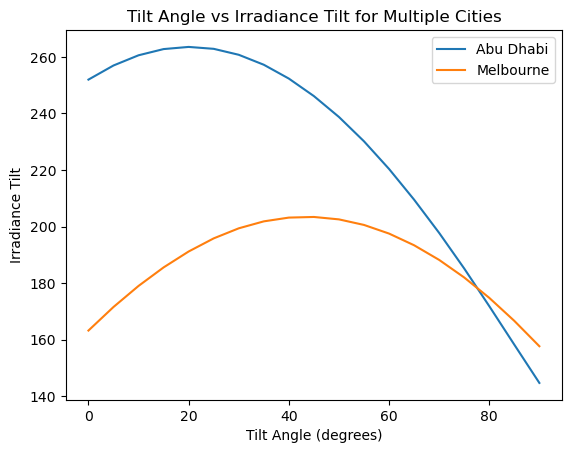

In [7]:
data_by_city = {city: [] for city in Cities}

for idx, city_data in enumerate(final_list):
    data_by_city[Cities[idx]].extend(city_data)

# Plotting the data
fig, ax = plt.subplots()

for city, city_data in data_by_city.items():
    tilt_angles, irradiance_values = zip(*city_data)
    ax.plot(tilt_angles, irradiance_values, label=f'{city}')

# Adding labels and title
ax.set_xlabel('Tilt Angle (degrees)')
ax.set_ylabel('Irradiance Tilt')
ax.set_title('Tilt Angle vs Irradiance Tilt for Multiple Cities')

# Displaying legend
ax.legend()

# Showing the plot
plt.show()

In [59]:
sandia_modules=pvlib.pvsystem.retrieve_sam('SandiaMod')
Module=sandia_modules['SolarWorld_Sunmodule_250_Poly__2013_']
globalirr=total_irrad.poa_global
airtemp=tmy.T2m
windspeed=tmy.WS10m
#Calculating cell_temp by assuming a,b and delT according to documentation
cell_temp = pvlib.temperature.sapm_cell(poa_global=globalirr, temp_air=airtemp, wind_speed=windspeed, a=-3.47, b=-0.0594, deltaT=3, irrad_ref=1000.0)
#print(cell_temp)
direct=total_irrad.poa_direct
diffuse=total_irrad.poa_diffuse
abs_AM=[]
for j in range (len(tmy.SZA)):
        airmass_relative = pvlib.atmosphere.get_relative_airmass(zenith = tmy.SZA [j] , model='kastenyoung1989')
        #print (airmass_relative)
        airmass_abs = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure=101325.0)
        abs_AM.append(airmass_abs)
#print(abs_AM)
#Need to vary tilt and azimuth
Aoi = pvlib.irradiance.aoi(surface_tilt=20, surface_azimuth=90, solar_zenith=tmy['SZA'], solar_azimuth=tmy['SAA'])
#print(aoi)
poa_effective=pvlib.pvsystem.sapm_effective_irradiance(poa_direct=direct, poa_diffuse=diffuse, airmass_absolute=abs_AM, aoi=Aoi, module=Module)
#print(poa_effective)
dc_power=pvlib.pvsystem.pvwatts_dc(g_poa_effective=poa_effective, temp_cell=cell_temp, pdc0=250, gamma_pdc=-0.0045 , temp_ref=25.0)
#print(dc_power)

2021-01-01 00:00:00    102.929925
2021-01-01 01:00:00    101.515656
2021-01-01 02:00:00    100.824390
2021-01-01 03:00:00    100.899541
2021-01-01 04:00:00    101.736216
2021-01-01 05:00:00    103.281234
2021-01-01 06:00:00    105.429273
2021-01-01 07:00:00    107.890445
2021-01-01 08:00:00    111.168119
2021-01-01 09:00:00    114.318551
2021-01-01 10:00:00    117.415748
2021-01-01 11:00:00    120.244606
2021-01-01 12:00:00    122.588821
2021-01-01 13:00:00    124.249862
2021-01-01 14:00:00    125.073718
2021-01-01 15:00:00    124.979078
2021-01-01 16:00:00    123.975103
2021-01-01 17:00:00    122.159299
2021-01-01 18:00:00    119.696707
2021-01-01 19:00:00    116.791174
2021-01-01 20:00:00    113.659896
2021-01-01 21:00:00    110.516151
2021-01-01 22:00:00    107.381140
2021-01-01 23:00:00    104.907507
2021-01-02 00:00:00    102.858237
2021-01-02 01:00:00    101.437799
2021-01-02 02:00:00    100.740079
2021-01-02 03:00:00    100.808909
2021-01-02 04:00:00    101.639771
2021-01-02 05: